In [1]:
import random
random.seed = 42

import seaborn as sns
import pandas as pd
import numpy as np
#import keras
#from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.listdir('input')

['HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv']

In [3]:
base_dir = 'base_dir'
os.mkdir(base_dir)


train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)


val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# creating new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)



# creating new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)

In [4]:
df_data = pd.read_csv('input/HAM10000_metadata.csv')
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Text(0.5, 1.0, 'Frequency Distribution of Diseases')

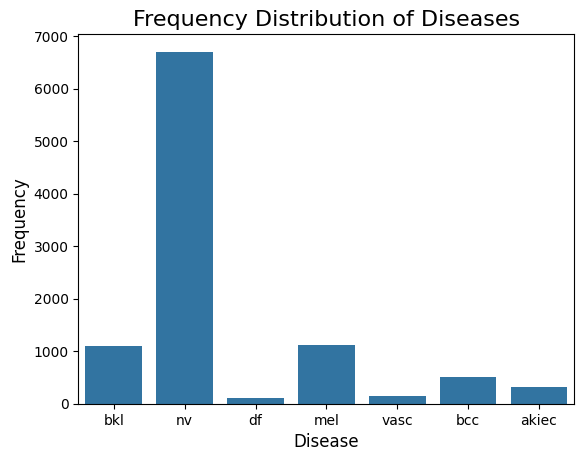

In [5]:
sns.countplot(x = df_data['dx'], data = df_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Diseases', size=16)

Text(0.5, 1.0, 'Gender of Patient')

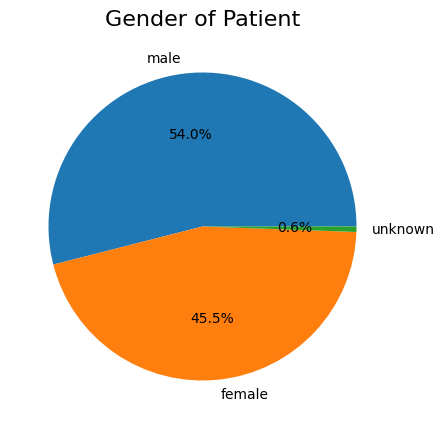

In [6]:
bar, ax = plt.subplots(figsize = (5,5))
plt.pie(df_data['sex'].value_counts(), labels = df_data['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

Text(0.5, 1.0, 'Histogram of Age of Patients')

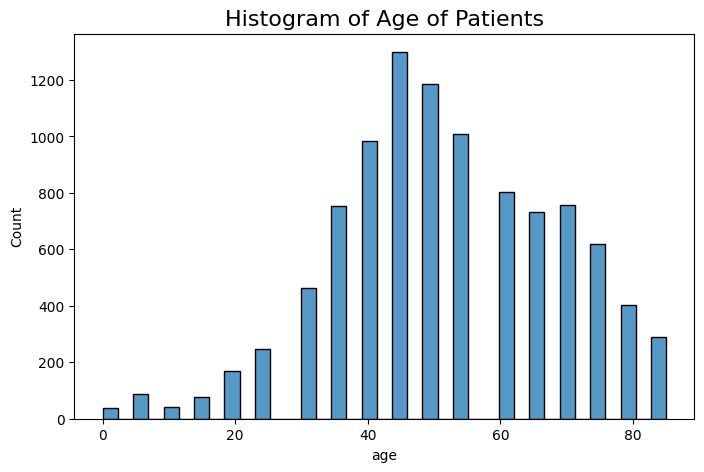

In [7]:
bar, ax = plt.subplots(figsize=(8,5))
sns.histplot(df_data['age'])
plt.title('Histogram of Age of Patients', size=16)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'back'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'scalp'),
  Text(9, 0, 'neck'),
  Text(10, 0, 'unknown'),
  Text(11, 0, 'hand'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear'),
  Text(14, 0, 'acral')])

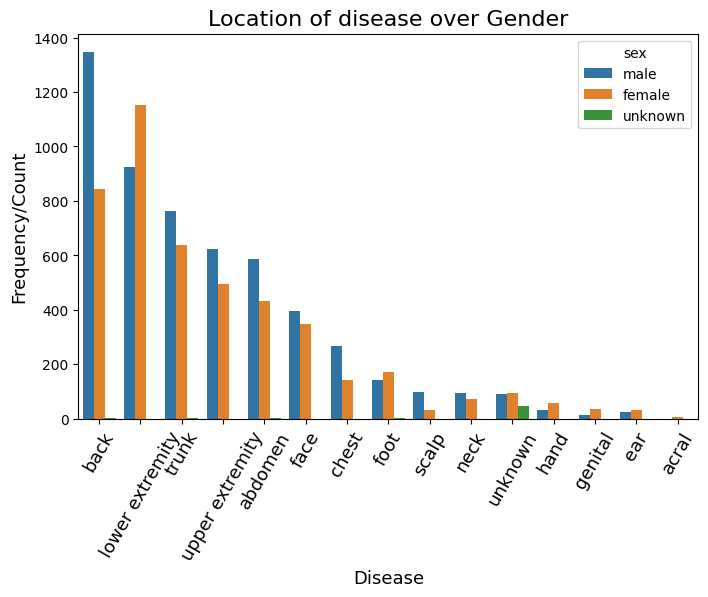

In [29]:
value = df_data[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (8, 5))
sns.barplot(x = 'location',  y='count', hue = 'sex',  data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=13)
plt.ylabel('Frequency/Count', size=13)
plt.xticks(rotation = 60, fontsize=13)

In [30]:
df = df_data.groupby('lesion_id').count()

df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.shape

(5514, 7)

In [31]:
def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    

df_data['duplicates'] = df_data['lesion_id']
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)
df = df_data[df_data['duplicates'] == 'no_duplicates']
y = df['dx']

_, df_val = train_test_split(df, test_size=0.20, random_state=101, stratify=y)

def identify_val_rows(x):
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'


df_data['train_or_val'] = df_data['image_id']

df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

8912
1103


In [32]:
df_data.set_index('image_id', inplace=True)

In [33]:
folder_1 = os.listdir('input/HAM10000_images_part_1')
folder_2 = os.listdir('input/HAM10000_images_part_2')

train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        src = os.path.join('input/HAM10000_images_part_1', fname)
        dst = os.path.join(train_dir, label, fname)
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join('input/HAM10000_images_part_2', fname)
        dst = os.path.join(train_dir, label, fname)
        shutil.copyfile(src, dst)


for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        src = os.path.join('input/HAM10000_images_part_1', fname)
        dst = os.path.join(val_dir, label, fname)
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join('input/HAM10000_images_part_2', fname)
        dst = os.path.join(val_dir, label, fname)
        shutil.copyfile(src, dst)

In [34]:
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5822
1067
1011
479
297
129
107


In [35]:
print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

883
46
88
35
30
13
8


In [36]:
class_list = ['mel','bkl','bcc','akiec','vasc','df']
# class_list = ['vasc','df']
for item in class_list:
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_class = item

    img_list = os.listdir('base_dir/train_dir/' + img_class)

    for fname in img_list:
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            dst = os.path.join(img_dir, fname)
            shutil.copyfile(src, dst)


    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,

        fill_mode='nearest')

    batch_size = 10

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)

    
    num_aug_images_wanted = 5900

    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))+1
    print(num_batches)
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    shutil.rmtree('aug_dir')

Found 1067 images belonging to 1 classes.
485
Found 1011 images belonging to 1 classes.
490
Found 479 images belonging to 1 classes.
544
Found 297 images belonging to 1 classes.
562
Found 129 images belonging to 1 classes.
579
Found 107 images belonging to 1 classes.
581


In [37]:
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5822
5905
5875
5908
5863
5875
5761
